In [22]:
from utils import load_data_from_csv, c_index
from sklearn.model_selection import train_test_split 
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import random
from six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image 
import pydotplus

# Load dataset 

In [23]:
X_train_org, X_test, y_train_org, y_test = load_data_from_csv(threshold=10, test_size=0.2)

In [24]:
print("X_train shape:", X_train_org.shape)
print("X_test shape:", X_test.shape)

X_train shape: (6863, 18)
X_test shape: (1716, 18)


In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_train_org, y_train_org, test_size=0.25, random_state=42)

In [26]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (5147, 18)
X_val shape: (1716, 18)
X_test shape: (1716, 18)


# Random Forest 

In [27]:
random_forest_default = RandomForestClassifier(n_estimators=50, random_state=42)
random_forest_default.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [28]:
# train C-index score
y_train_predict = random_forest_default.predict_proba(X_train)[:, 1]
print("C-index score for Random Forest:", c_index(y_train, y_train_predict))

C-index score for Random Forest: 1.0


In [29]:
# validation
y_pred_val = random_forest_default.predict_proba(X_val)[:, 1]
print("Validation C-index:", c_index(y_val, y_pred_val))

# test
y_pred_test = random_forest_default.predict_proba(X_test)[:, 1]
print("Test C-index:", c_index(y_test, y_pred_test))

Validation C-index: 0.7370878013567458
Test C-index: 0.7506640680431389


# Change hyperparameters

In [31]:
# train with hypertuning
random_forest_hypertuning = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=20, min_samples_leaf=10, random_state=42)
random_forest_hypertuning.fit(X_train, y_train)


# train C-index score
y_train_predict = random_forest_hypertuning.predict_proba(X_train)[:, 1]
print("C-index score for Random Forest:", c_index(y_train, y_train_predict))

C-index score for Random Forest: 0.907367369725477


In [32]:
# validation c-index score
y_pred_val = random_forest_hypertuning.predict_proba(X_val)[:, 1]
print("Validation C-index:", c_index(y_val, y_pred_val))

# test c-index score
y_pred_test = random_forest_hypertuning.predict_proba(X_test)[:, 1]
print("Test C-index:", c_index(y_test, y_pred_test))

Validation C-index: 0.7625034442397509
Test C-index: 0.7603856250886902


### GRID SEARCH RANDOM FOREST 

In [11]:
import itertools

def grid_search(tree, X_train, y_train, X_val, y_val, hyperparams, fixed_hyperparams={}):
    best_estimator = None
    best_hyperparams = {}
    
    best_score = 0.0
    lists = hyperparams.values()
    
    param_combinations = list(itertools.product(*lists))
    total_param_combinations = len(param_combinations)


    for i, params in enumerate(param_combinations, 1):
        param_dict = {}
        for param_index, param_name in enumerate(hyperparams):
            param_dict[param_name] = params[param_index]
            
        # create estimator with specified params
        estimator = tree(**param_dict, **fixed_hyperparams)
        estimator.fit(X_train, y_train)
        
        preds = estimator.predict_proba(X_val)
        
        # compute cindex for predictions
        estimator_score = c_index(y_val, preds[:,1])

        print(f'[{i}/{total_param_combinations}] {param_dict}')
        print(f'Val C-Index: {estimator_score}\n')

        # update and get best hyperparams
        if estimator_score >= best_score:
                best_score = estimator_score
                best_estimator = estimator
                best_hyperparams = param_dict

    best_hyperparams.update(fixed_hyperparams)
    return best_estimator, best_hyperparams, best_score

In [12]:
decision_tree_hyperparams = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 3, 5, 10, 50, 100],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20, 50, 100],
}
fixed_hyperparams = {
        'random_state': 42,
}

In [13]:
random_forest = RandomForestClassifier

In [14]:
best_estimator, best_hyperparams,best_score = grid_search(random_forest, X_train, y_train, X_val, y_val, decision_tree_hyperparams, fixed_hyperparams)

[1/864] {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}
Val C-Index: 0.7054281218475243

[2/864] {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5}
Val C-Index: 0.7285164833913635

[3/864] {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 10}
Val C-Index: 0.7379121417136715

[4/864] {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 20}
Val C-Index: 0.7424004700106345

[5/864] {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 50}
Val C-Index: 0.7461578224662351

[6/864] {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 100}
Val C-Index: 0.7536190135697354

[7/864] {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1}
Val C-Index: 0.7187120706655523

[8/864] {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 5}
Val 

In [15]:
best_score

0.7625034442397509

In [16]:
best_hyperparams

{'n_estimators': 50,
 'max_depth': 10,
 'min_samples_split': 20,
 'min_samples_leaf': 10,
 'random_state': 42}

### Explan Random Forest

In [17]:
import shap

X_test_risk = X_test.copy(deep=True)
X_test_risk.loc[:, 'risk'] = best_estimator.predict_proba(X_test_risk)[:, 1]
X_test_risk = X_test_risk.sort_values(by='risk', ascending=False)
X_test_risk.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,risk
3592,69.0,90.0,85.0,2.0,41.8,44.0,4.5,224.0,60.0,1.70,8.1,1.0,175.0,448.0,13.4,8.4,26.933909,85.0,0.721992
3750,74.0,80.0,93.0,1.0,46.0,41.0,4.2,157.0,65.0,1.50,7.9,1.0,190.0,336.0,19.3,6.7,27.422433,110.0,0.713887
2469,70.0,70.0,54.0,1.0,44.5,24.0,4.3,205.0,206.0,1.78,7.9,1.0,190.0,343.0,60.1,7.7,17.595799,120.0,0.676873
1657,69.0,68.0,118.0,2.0,42.1,23.0,3.9,174.0,126.0,0.98,7.0,1.0,140.0,272.0,46.3,9.3,21.686389,72.0,0.668553
2813,73.0,70.0,107.0,2.0,45.4,44.0,3.8,282.0,99.0,1.53,6.8,1.0,180.0,270.0,36.7,5.5,20.344681,110.0,0.663069


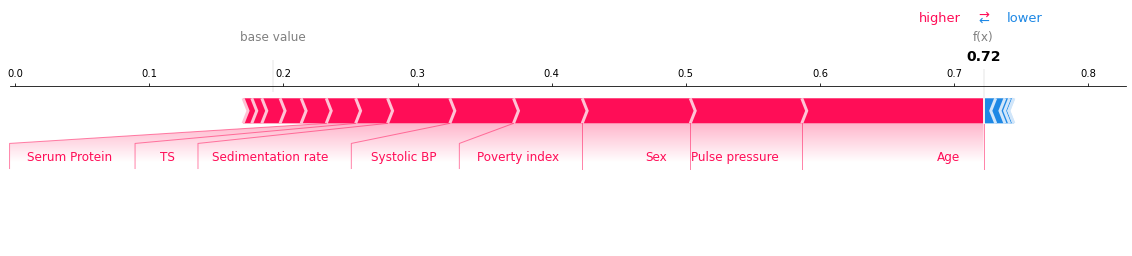

In [18]:
explainer = shap.TreeExplainer(best_estimator)
i = 0
shap_value = explainer.shap_values(X_test.loc[X_test_risk.index[i], :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

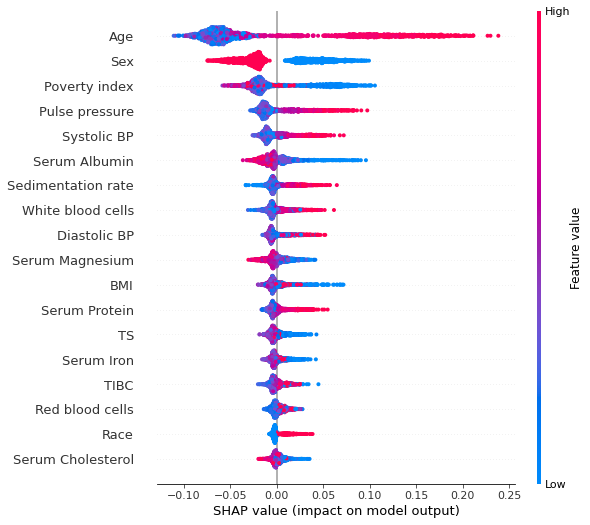

In [19]:
shap_values = shap.TreeExplainer(best_estimator).shap_values(X_test)[1]
shap.summary_plot(shap_values, X_test)

#### Phân tích ảnh hưởng của các trường dữ liệu với nhau 

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


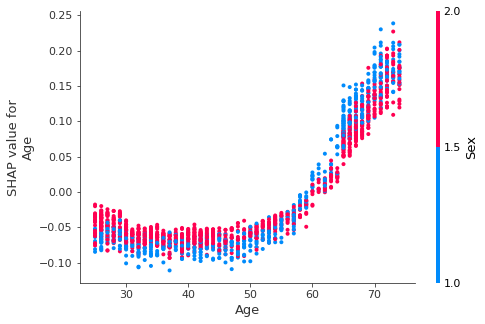

In [20]:
shap.dependence_plot('Age', shap_values, X_test, interaction_index='Sex')

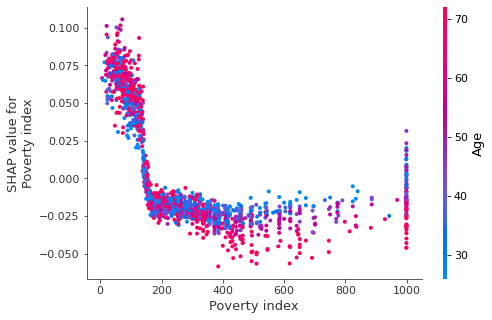

In [21]:
shap.dependence_plot('Poverty index', shap_values, X_test, interaction_index='Age')